In [29]:
%load_ext autoreload
%autoreload 2

from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import json
import sys
sys.path.append('../visualizations/phase_diagram_viz')
import utils as pd_utils

import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel
from gpytorch.priors import GammaPrior

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

sys.path.append('/home/ubuntu/Code/silica-np-synthesis/')
from sample_utilities import samples

from scipy.stats.qmc import Sobol
from scipy.stats import qmc

import uuid

from joblib import Parallel, delayed

import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

In [169]:
#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10
amplitude_weight = 0.1




### Experiment 'execution' parameters

In [170]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

### Campaign structure 

In [176]:
## Sobol sample
seed = 42
m_samples = 5 # 2**m_samples = n_samples default 5

BATCH_SIZE = 1  if not SMOKE_TEST else 2




In [172]:
n_batches

100

### BO/GPR things

In [173]:

NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

### 1. define ground truth functions

In [50]:
def particle_diameter(x_1, x_2, x_3):
    const = 57.36
    a = const
    b = 6*const
    c = 6*const

    diameter = a*np.log(x_1) + b*np.exp(x_2)+c*x_3

    
    return diameter

In [51]:
def particle_pdi_gaussian(x_1, x_2, x_3, mu_x=0.007, mu_y=0.025, mu_z=0.03, sigma_x1=0.08, sigma_x2=0.1, sigma_x3=5, amplitude=1, offset=1.1):
    """
    Computes the value of a 3D Gaussian function at (x, y, z).
    
    Parameters:
    x, y, z : float or np.array
        Input coordinates where the function is evaluated.
    mu_x, mu_y, mu_z : float
        Center (mean) of the Gaussian in each dimension.
    sigma_x, sigma_y, sigma_z : float
        Standard deviations in x, y, and z directions.
    amplitude : float
        Peak value of the Gaussian.
    offset : float
        Baseline offset added to the function.

    Returns:
    float or np.array
        The computed Gaussian function value.
    """
    exponent = -(((x_1 - mu_x)**2 / (2 * sigma_x1**2)) + 
                 ((x_2 - mu_y)**2 / (2 * sigma_x2**2)) + 
                 ((x_3 - mu_z)**2 / (2 * sigma_x3**2)))
    return -amplitude * np.exp(exponent) + offset


### 2. Calculate scattering

In [52]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [53]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [54]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

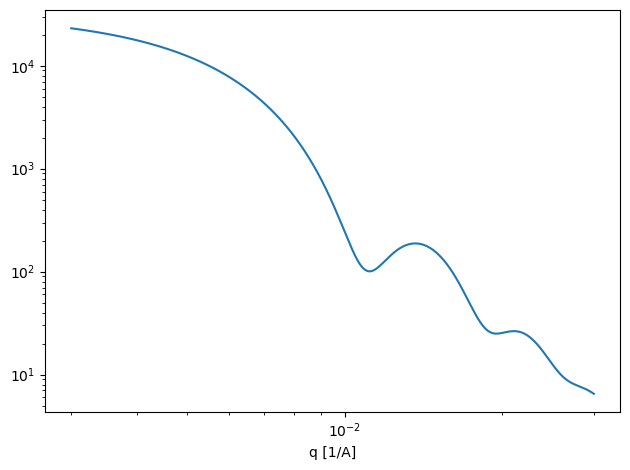

In [55]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


## 3. put together 'experiment' code:

In [56]:
def syringe_precision(vol_frac, noise_frac):
    """
    vol_frac - volume fraction to be noised
    noise-frac - what fraction of full syringe uncertainty to use (0 is noise free, 1 is full)
    """
    if vol_frac <= 0.029:
        precision = noise_frac* (-3551*vol_frac + 110)/100
    else:
        precision = noise_frac*0.0073

    return precision

In [57]:
def noisy_dispense(vol_frac, noise_frac):
    """
    calculate the 'noisy' amount to 'dispense' when calculating diameter, pdi

    vol frac - volume fraction 'called for' by planner
    noise_frac - noise parameter, [0,1], 1 is syringe noise, 0 is noise free

    will not return less than 0.003 to prevent negative diameters
    """

    vol_std = syringe_precision(vol_frac, noise_frac)*vol_frac
    sampled_vol_frac = np.random.normal(loc = vol_frac, scale=vol_std)
    if sampled_vol_frac < 0.003:
        sampled_vol_frac = 0.003
    return sampled_vol_frac

In [58]:
# something provides volume fractions to use
def run_experiment(sample_point, noise_frac):
    """
    Takes an ideal sample point, returns scattering and real point sampled 
    """
    noisy_sample_point = [noisy_dispense(sample_point[0], noise_frac), noisy_dispense(sample_point[1], noise_frac), noisy_dispense(sample_point[2], noise_frac)]
    
    diameter = particle_diameter(noisy_sample_point[0], noisy_sample_point[1], noisy_sample_point[2])
    pdi = particle_pdi_gaussian(noisy_sample_point[0], noisy_sample_point[1], noisy_sample_point[2])
    
    target_r_angs = diameter*10/2
    
    scattering = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, pdi, sld_silica, sld_etoh)

    return scattering, noisy_sample_point, diameter, pdi

## 4. Data processing

- just do scaling and AP distance here

In [59]:
def process_measurement(scattering, target_I, q_grid, amplitude_weight):
    # processing works in log(I) space 

    
    scattering = np.log10(scattering)
    I_scaled = manipulate.scale_intensity_highqavg(scattering, target_I, n_avg = n_avg)
    amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)

    ap_sum = amplitude_weight*amplitude + (1-amplitude_weight)*phase
    ap_sum_report = 0.1 * amplitude + 0.9*phase

    return ap_sum, ap_sum_report, I_scaled

## 5. BO 

function call to do BO 

In [60]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = ard_num_dims)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        #train_Yvar=assumed_noise*torch.ones_like(train_y),
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [61]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [62]:
def bayesian_optimize(x_train, y_train, batch_size, num_restarts, raw_samples, nu, ard_num_dims, bounds_torch_opt, bounds_torch_norm):
    ## init model
    mll_nei, model_nei = initialize_model(x_train, y_train, ard_num_dims = ard_num_dims)    
    fit_mll = fit_gpytorch_mll(mll_nei)

    ## run acq opt
    # define the qEI and qNEI acquisition modules using a QMC sampler
    t_acqf = time.time()
    qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([raw_samples]))
    
    # for best_f, we use the best observed noisy values as an approximation
    qLogNEI = qLogNoisyExpectedImprovement(
        model=model_nei,
        X_baseline=x_train,
        sampler=qmc_sampler,
        objective=objective,
        prune_baseline=True,
    )
    
    # optimize for new candidates
    candidates, _ = optimize_acqf(
        acq_function=qLogNEI,
        bounds=bounds_torch_opt,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for intialization heuristic
        #options={"batch_limit": 5, "maxiter": 200},
    )
    print(f'Optimized acqf in {time.time() - t_acqf} s')
    x_fractions = unnormalize(candidates, bounds_torch_norm)

    return x_fractions
    

In [63]:
def bo_preprocess(current_dataset, bounds_torch_norm):
    """
    Get current data into good form for BO
    """
    compositions = []
    apdist_vals = []
    for uiud_val, sample in current_dataset.items():
        comp = [sample['teos_vol_frac'], sample['ammonia_vol_frac'], sample['water_vol_frac']]
        compositions.append(comp)
        apdist_vals.append(sample['ap_distance'])

    y_data = - torch.tensor(np.array(apdist_vals)).reshape(-1,1)
    x_data_torch = torch.tensor(np.array(compositions))


    x_data_norm = normalize(x_data_torch, bounds_torch_norm)
    y_data_norm = normalize(y_data, (y_data.min(), y_data.max())).reshape(-1,1)

    return x_data_norm, y_data_norm

    
    
    
    

In [64]:
def bo_postprocess(candidates):
    batch = {}
    for i in range(len(candidates)):
        sample = {}
        uuid_val = str(uuid.uuid4())

        sample['teos_vol_frac'] = candidates[i,0]
        sample['ammonia_vol_frac'] = candidates[i,1]
        sample['water_vol_frac'] = candidates[i,2]

        batch[uuid_val] = sample

    return batch



        

## 6. Initial random sampling
Do sobol sampling here with n as a parameter

In [65]:
def sobol_sample(m_samples, seed, lower_bounds, upper_bounds):
    """
    Generate sobol sample and set up data structure
    """
    sampler = Sobol(d=3, seed = seed)
    sampled_points = sampler.random_base2(m_samples)

    sampled_volume_fractions = qmc.scale(sampled_points, lower_bounds, upper_bounds)


    sobol_samples = {}
    for i in range(len(sampled_volume_fractions)):
        uuid_val = str(uuid.uuid4())
        sample = {}
        sample['teos_vol_frac'] = sampled_volume_fractions[i,0]
        sample['ammonia_vol_frac'] = sampled_volume_fractions[i,1]
        sample['water_vol_frac'] = sampled_volume_fractions[i,2]

        sobol_samples[uuid_val] = sample

    return sobol_samples
        



In [66]:
target_I

array([4.36417317, 4.36349844, 4.36282045, ..., 0.81955602, 0.81610127,
       0.81256493])

## 7. Run experiment loop

- BO to get next batch of points
- run experiment and calculate distance


data structure:
- uuid indexed dict
- uuid generated when compositions generated
- track vol fracs (desired), vol fracs (real), scattering, ap distance

BO sees vol fracs (desired) and AP distance

In [67]:

def process_sample(uuid_val, sample, target_I, q_grid, amplitude_weight):
    """ Runs the experiment for a single sample and returns the results. """
    sample_point = [sample['teos_vol_frac'], sample['ammonia_vol_frac'], sample['water_vol_frac']]
    scattering, real_sample_point, diameter, pdi = run_experiment(sample_point, noise_frac)
    
    # Process measurement
    ap_dist, ap_dist_report, I_scaled = process_measurement(scattering, target_I, q_grid, amplitude_weight)

    return uuid_val, {
        'scattering_I': scattering,
        'real_sampled_point': real_sample_point,
        'diameter': diameter,
        'pdi': pdi,
        'ap_distance': ap_dist,
        'ap_distance_reporting': ap_dist_report,
        'I_scaled': I_scaled
    }

def batch_experiment(batch, target_I, q_grid, amplitude_weight, n_jobs=-1):
    """ Runs experiments in parallel using joblib. """
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_sample)(uuid_val, sample, target_I, q_grid, amplitude_weight) for uuid_val, sample in batch.items()
    )

    # Update batch with results
    for uuid_val, result in results:
        batch[uuid_val].update(result)


In [178]:
bounds_torch_norm

tensor([[0.0050, 0.0050, 0.0050],
        [0.1000, 0.1000, 0.1500]])

In [179]:
bounds_torch_opt

tensor([[0., 0., 0.],
        [1., 1., 1.]])

In [188]:
# 1. call sobol sampling to generate samples

def run_experiment(batch_size, amplitude_weight, m_samples, lower_bounds, upper_bounds, trial_name, noise_level, n_replicates = 3):

    
    if batch_size == 0:
        n_batches = 0
    else:
        n_batches = int(np.ceil(100/batch_size))
    
    bounds_torch_norm = torch.tensor([(lower_bounds[0], upper_bounds[0]), (lower_bounds[1], upper_bounds[1]), (lower_bounds[2], upper_bounds[2])]).transpose(-1, -2)
    bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

    print(f'Running optimization for trial {trial_name}')
    for rep_num in range(n_replicates):

        print('starting initial samples')
        initial_samples = sobol_sample(m_samples, seed, lower_bounds, upper_bounds)
        
        # 2. 'measure' sobol samples
        
        batch_experiment(initial_samples, target_I, q_grid, amplitude_weight)
        
        # 3. start experiment loop:
        data = initial_samples
        for i in range(n_batches):
            print(f'starting batch {i+1}')
            # 3a. Prepare and run BO
            x_train, y_train = bo_preprocess(data, bounds_torch_norm)
            candidates = bayesian_optimize(x_train, y_train, BATCH_SIZE, NUM_RESTARTS, RAW_SAMPLES, nu, ard_num_dims, bounds_torch_opt, bounds_torch_norm)
            candidates = bo_postprocess(candidates)
        
            # run experiment
            batch_experiment(candidates, target_I, q_grid, amplitude_weight)
        
            # update running data tally
            for uuid_val, sample in candidates.items():
                data[uuid_val] = sample

        
        with open(f'{trial_name}_replicate_{rep_num}.pkl', 'wb') as f:
            pickle.dump(data, f)
    
                  
        
        
    
#3c. post process and update datae 

In [189]:
trials = {'default':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'Batchsize_1':{
        'batch_size':1,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'Batchsize_10':{
        'batch_size':10,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'AmplitudeWeight_0':{
        'batch_size':5,
        'amplitude_weight':0,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'AmplitudeWeight_0point5':{
        'batch_size':5,
        'amplitude_weight':0.5,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'Bounds_restricted':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.6, 0.6, 0.6], 
        'noise_level':0.5
        },
     'NoiseLevel_1':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1
        },
    'SobolBaseline':{
        'batch_size':0,
        'amplitude_weight':0.1,
        'm_samples':7,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
    }

In [190]:
for trial_name, params in trials.items():
    batch_size = params['batch_size']
    amplitude_weight = params['amplitude_weight']
    m_samples = params['m_samples']
    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    noise_level = params['noise_level']

    run_experiment(batch_size, amplitude_weight, m_samples, lower_bounds, upper_bounds, trial_name, noise_level)

## 8. Analyze 

#### 1. Convergence plot

In [153]:
with open('APdistweight_0point1.pkl', 'rb') as f:
    data = pickle.load(f)

In [154]:

name_bounds = {}

name_bounds['random'] = (0, 2**m_samples)
for i in range(n_batches):
    name_bounds[f'Batch {i+1}'] = ((i)*BATCH_SIZE + 2**m_samples, (i+1)*BATCH_SIZE + 2**m_samples)
        

In [155]:
best_distances_ap = []
best_uuid = []
for uuid_val, sample in data.items():
    dist = sample['ap_distance_reporting']
    if len(best_distances_ap) == 0:
        best_distances_ap.append(dist)
        best_distances_ap.append(dist)
        best_uuid.append(uuid_val)
    else:
        best_distances_ap.append(min(best_distances_ap[-1], dist))

    
    if dist < best_distances_ap[-2]:
        print('new min found')
        best_uuid.append(uuid_val)

new min found
new min found
new min found
new min found


In [156]:
min(best_distances_ap)

0.06706172421021662

In [157]:
best_distances_ap[0]

0.4709955885133343

In [158]:
best_uuid

['eaccea88-b4f0-4fdf-976c-668cfe404976',
 'd435b0c7-04a9-47af-8b39-3a90ccf8adb5',
 'd3af1599-7ae6-46f9-b1c6-4a720b9dbe9a',
 '517aafff-f10a-4ea5-a834-b1c74a07cf11',
 '2481b0b9-c490-4953-8030-205771b78507']

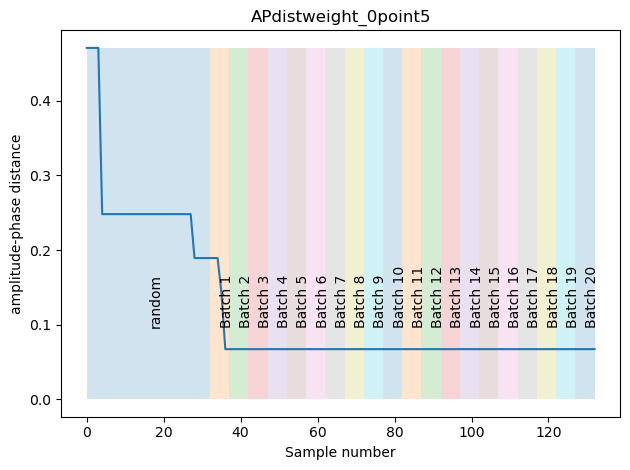

In [159]:
fig, ax = plt.subplots()

for name, bounds in name_bounds.items():
    ax.fill_between(bounds, 0, max(best_distances_ap), alpha = 0.2)
    ax.text(np.mean(bounds), 0.1, name, rotation = 'vertical')
ax.plot(best_distances_ap)


ax.set_xlabel('Sample number')
ax.set_ylabel('amplitude-phase distance')
ax.set_title(trial_name)

plt.tight_layout()
#plt.savefig('Campaign_convergence_plot.png', dpi = 300)

####  Phase plots

In [160]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def get_colormap_color(value, vmin, vmax, cmap_name='viridis'):
    """
    Maps a scalar value to an RGB color using a specified Matplotlib colormap.
    
    Parameters:
        value (float): The scalar value to be mapped to a color.
        vmin (float): The minimum bound of the scalar range.
        vmax (float): The maximum bound of the scalar range.
        cmap_name (str): The name of the Matplotlib colormap to use (default: 'viridis').
    
    Returns:
        tuple: An (R, G, B) color tuple, where values are in the range [0, 1].
    """
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    return cmap(norm(value))[:3]  # Extract only RGB values (ignoring alpha if present)

In [161]:
x_name = 'TEOS'
y_name = 'water'
y_2_name = 'ammonia'

x_min = teos_min_vf
x_max = teos_max_vf
y_min = water_min_vf
y_max = water_max_vf

y_2_min = ammonia_min_vf
y_2_max = ammonia_max_vf

bounds = np.array([[x_min, y_min], [x_max, y_max]])
bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])

/tmp/ipykernel_3065/294263709.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


<function plot_phasemap.<locals>.<lambda> at 0x71e1d4a33ec0>


/tmp/ipykernel_3065/201713339.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Text(0.5, 0.98, 'Round 2 Optimization Batch 3 - APdist')

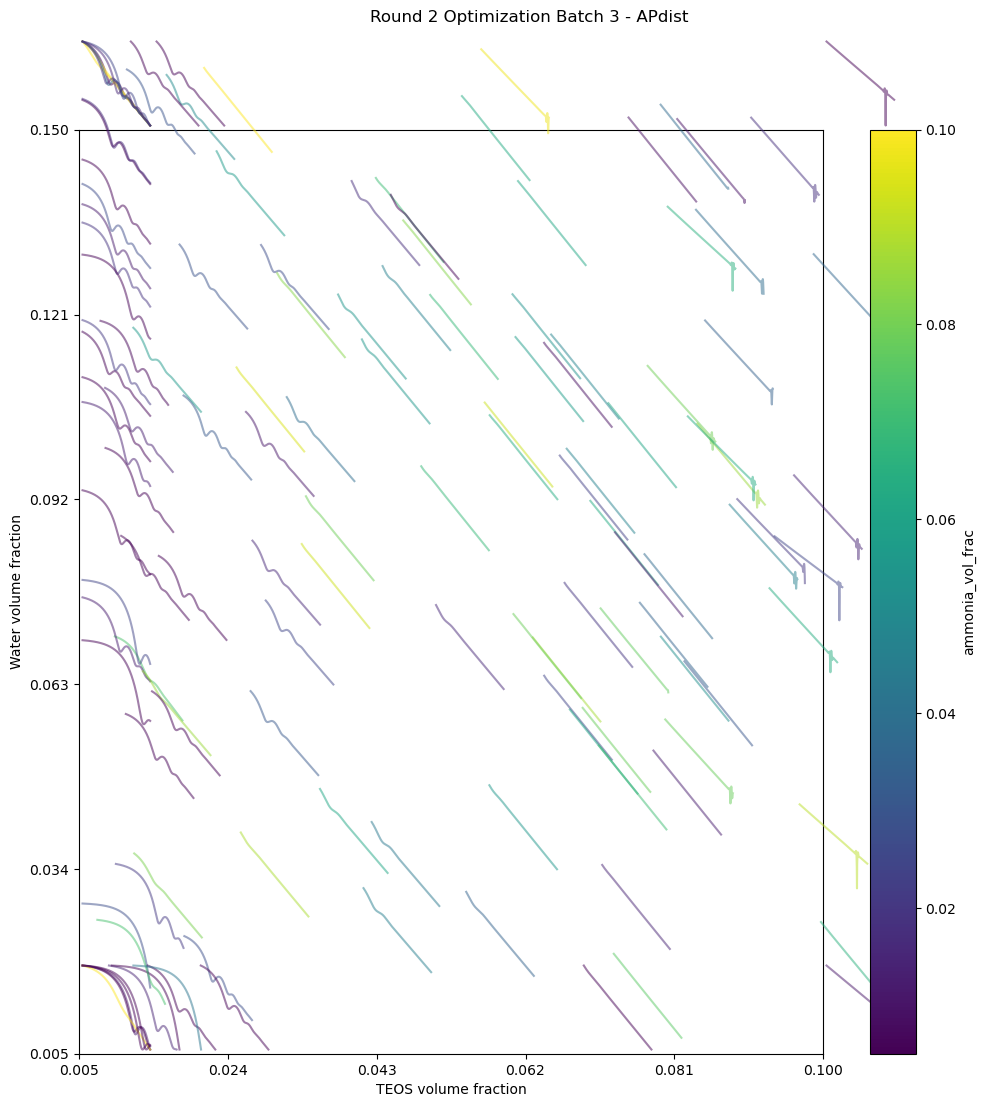

In [162]:
x_key = 'teos_vol_frac'
y_key = 'water_vol_frac'
y_2_key = 'ammonia_vol_frac'


fig, ax = plt.subplots(figsize = (12,12))

c_1 = []
s = []
c_2 = []

colors_1 = []
colors_2 = []
for uuid_val, sample in data.items():

    x_val = sample[x_key]
    y_val = sample[y_key]
    y_2_val = sample[y_2_key]

    
    I = np.log10(sample['scattering_I'])
    

    q = q_grid

    c_1.append([x_val, y_val])
    s.append(I)
    c_2.append([x_val, y_2_val])
    colors_1.append(get_colormap_color(y_2_val, y_2_min, y_2_max))
    colors_2.append(get_colormap_color(y_val, y_min, y_max))

        

s = np.array(s)

pd_utils.plot_phasemap(bounds, ax, c_1, s, colors = colors_1, scale_axis=True)
#pd_utils.plot_phasemap(bounds_2, ax[1], c_2, s, colors = colors_2)


ax.set_xlabel('TEOS volume fraction')
ax.set_ylabel('Water volume fraction')
#ax[1].set_xlabel('TEOS volume fraction')
#ax[1].set_ylabel('Ammonia volume fraction')

cmap_name = 'viridis'
norm = mcolors.Normalize(vmin=y_2_min, vmax=y_2_max)
cmap = cm.get_cmap(cmap_name)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label(y_2_key)


fig.suptitle('Round 2 Optimization Batch 3 - APdist')
#plt.savefig('Phaseplot_apdist_batch3_80nm.png', dpi = 300)

In [163]:
best_uuid

['eaccea88-b4f0-4fdf-976c-668cfe404976',
 'd435b0c7-04a9-47af-8b39-3a90ccf8adb5',
 'd3af1599-7ae6-46f9-b1c6-4a720b9dbe9a',
 '517aafff-f10a-4ea5-a834-b1c74a07cf11',
 '2481b0b9-c490-4953-8030-205771b78507']

## Plot best scatterer

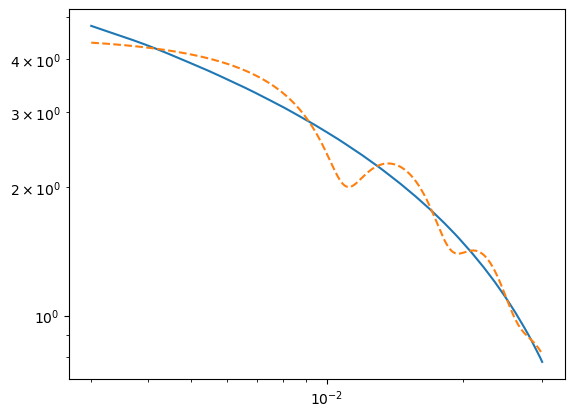

In [168]:
I = data[best_uuid[-5]]['I_scaled']

fig, ax = plt.subplots()

ax.loglog(q_grid_nonlog, I)
ax.loglog(q_grid_nonlog, target_I, ls ='--')

In [140]:
data[best_uuid[-1]]

{'teos_vol_frac': tensor(0.0050),
 'ammonia_vol_frac': tensor(0.0327),
 'water_vol_frac': tensor(0.0700),
 'scattering_I': array([2.36424423e+04, 2.36049121e+04, 2.35672615e+04, ...,
        6.51462484e+00, 6.45786412e+00, 6.40059396e+00]),
 'real_sampled_point': [0.0054252673043443935,
  0.03275345971863133,
  0.07034030973783803],
 'diameter': 80.59815947153709,
 'pdi': 0.10322686917436141,
 'ap_distance': 0.047236707849199214,
 'ap_distance_reporting': 0.03734046550562381,
 'I_scaled': array([4.37836572, 4.37767577, 4.37698251, ..., 0.8185628 , 0.81476229,
        0.81089366])}

In [174]:
amplitude_weight

0.1